In [13]:
# Import the required libraries and dependencies
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [14]:
# pull in the data frame
combined_start = pd.read_csv("Final_File\combined.csv")
combined_start['date'] = pd.to_datetime(combined_start['date'])

display(combined_start)

,date,close,volume,close_1_day_prior,close_1_week_prior,pct_change_1_day,pct_change_1_week,ticker_sentiment_score_aftermarket,ticker_sentiment_score_intraday,ticker_sentiment_score_pre-market,relevance_weighted_sentiment_score_aftermarket,relevance_weighted_sentiment_score_intraday,relevance_weighted_sentiment_score_pre-market,GICS Sector,GICS Sub-Industry
0,2023-12-29,109.32,2414408,109.69,105.56,-0.003373,0.035620,0.0,-0.133600,0.0,0.0,-0.033975,0.0,Industrials,Industrial Conglomerates
1,2023-12-28,109.69,2809576,108.74,103.67,0.008736,0.058069,0.0,0.000000,0.0,0.0,0.000000,0.0,Industrials,Industrial Conglomerates
2,2023-12-27,108.74,2428836,108.11,106.25,0.005827,0.023435,0.0,0.000000,0.0,0.0,0.000000,0.0,Industrials,Industrial Conglomerates
3,2023-12-26,108.11,2786348,106.33,105.87,0.016740,0.021158,0.0,0.000000,0.0,0.0,0.000000,0.0,Industrials,Industrial Conglomerates
4,2023-12-22,106.33,2281685,105.56,106.98,0.007294,-0.006076,0.0,0.014477,0.0,0.0,0.001547,0.0,Industrials,Industrial Conglomerates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116220,2023-01-09,147.06,1700683,147.64,146.55,-0.003928,0.003480,0.0,0.000000,0.0,0.0,0.000000,0.0,Health Care,Pharmaceuticals
116221,2023-01-06,147.64,1761250,145.45,148.15,0.015057,-0.003442,0.0,0.000000,0.0,0.0,0.000000,0.0,Health Care,Pharmaceuticals
116222,2023-01-05,145.45,1560866,148.96,143.83,-0.023563,0.011263,0.0,0.178479,0.0,0.0,0.129767,0.0,Health Care,Pharmaceuticals
116223,2023-01-04,148.96,1796063,146.85,145.30,0.014368,0.025189,0.0,0.000000,0.0,0.0,0.000000,0.0,Health Care,Pharmaceuticals


In [15]:
# review the data types
combined_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116225 entries, 0 to 116224
Data columns (total 15 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   date                                            116225 non-null  datetime64[ns]
 1   close                                           116225 non-null  float64       
 2   volume                                          116225 non-null  int64         
 3   close_1_day_prior                               116225 non-null  float64       
 4   close_1_week_prior                              116225 non-null  float64       
 5   pct_change_1_day                                116225 non-null  float64       
 6   pct_change_1_week                               116225 non-null  float64       
 7   ticker_sentiment_score_aftermarket              116225 non-null  float64       
 8   ticker_sentiment_score_intraday   

In [16]:
# return it to an UNSCALED data frame
unscaled_data_df = combined_start.drop(['date',
                                        'close',
                                        'volume',
                                        'pct_change_1_day',
                                        'pct_change_1_week',
                                        'close_1_day_prior',
                                        'close_1_week_prior',
                                        'ticker_sentiment_score_aftermarket',
                                        'ticker_sentiment_score_intraday',	
                                        'ticker_sentiment_score_pre-market',
                                        'GICS Sector',
                                        'GICS Sub-Industry'], axis=1)


display(unscaled_data_df)

,relevance_weighted_sentiment_score_aftermarket,relevance_weighted_sentiment_score_intraday,relevance_weighted_sentiment_score_pre-market
0,0.0,-0.033975,0.0
1,0.0,0.000000,0.0
2,0.0,0.000000,0.0
3,0.0,0.000000,0.0
4,0.0,0.001547,0.0
...,...,...,...
116220,0.0,0.000000,0.0
116221,0.0,0.000000,0.0
116222,0.0,0.129767,0.0
116223,0.0,0.000000,0.0


In [17]:
#create the bin ranges - min, -4%, 0, 4%,
binned_change = pd.DataFrame()

# Define custom bin edges
min_value = combined_start['pct_change_1_day'].min()
max_value = combined_start['pct_change_1_day'].max()
bin_edges = [min_value-1, 0, max_value+1]

binned_change['pct_change_1_day'] = pd.cut(combined_start['pct_change_1_day'], bins=bin_edges, labels=False)
print(binned_change)

        pct_change_1_day
0                      0
1                      1
2                      1
3                      1
4                      1
...                  ...
116220                 0
116221                 1
116222                 0
116223                 1
116224                 1

[116225 rows x 1 columns]


In [18]:
# Count NaN values in each column
nan_count = binned_change.isnull().sum()
print(nan_count)

pct_change_1_day    0
dtype: int64


In [19]:
# encode the data columns into day, month and year columns
dates = pd.DataFrame()
dates['year'] = combined_start['date'].dt.year
dates['month'] = combined_start['date'].dt.month
dates['day'] = combined_start['date'].dt.day

display(dates)

,year,month,day
0,2023,12,29
1,2023,12,28
2,2023,12,27
3,2023,12,26
4,2023,12,22
...,...,...,...
116220,2023,1,9
116221,2023,1,6
116222,2023,1,5
116223,2023,1,4


In [20]:
# onehot encode the month & date
mon_oh = pd.DataFrame()
mon_oh['month'] = combined_start['date'].dt.month
mon_oh = pd.get_dummies(mon_oh, columns=['month'])
mon_oh = mon_oh.astype(int)

display(mon_oh)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
116220,1,0,0,0,0,0,0,0,0,0,0,0
116221,1,0,0,0,0,0,0,0,0,0,0,0
116222,1,0,0,0,0,0,0,0,0,0,0,0
116223,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# create a label encoded day field
le = LabelEncoder()
day = pd.DataFrame()
day['day'] = combined_start['date'].dt.dayofweek
day['encoded_day'] = le.fit_transform(day['day'])
day = day.drop('day', axis=1)

display(day)

,encoded_day
0,4
1,3
2,2
3,1
4,4
...,...
116220,0
116221,4
116222,3
116223,2


In [22]:
# onehot encode the weekdays
day_oh = pd.DataFrame()
day_oh['day'] = combined_start['date'].dt.dayofweek
day_oh = pd.get_dummies(day_oh, columns=['day'])
day_oh = day_oh.astype(int)

display(day_oh)

,day_0,day_1,day_2,day_3,day_4
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
116220,1,0,0,0,0
116221,0,0,0,0,1
116222,0,0,0,1,0
116223,0,0,1,0,0


In [23]:
# label encode the sector field
sector = pd.DataFrame()
sector['sector_encoded'] = le.fit_transform(combined_start['GICS Sector'])

display(sector)

,sector_encoded
0,6
1,6
2,6
3,6
4,6
...,...
116220,5
116221,5
116222,5
116223,5


In [24]:
# onehot encode the sector & industry
sec_ind_oh = pd.DataFrame()
# sec_ind_oh['sector_oh'] = combined_start['GICS Sector']
sec_ind_oh['industry_oh'] = combined_start['GICS Sub-Industry']
sec_ind_oh = pd.get_dummies(sec_ind_oh, columns=['industry_oh'])
sec_ind_oh = sec_ind_oh.astype(int)

display(sec_ind_oh)

,industry_oh_Advertising,industry_oh_Aerospace & Defense,industry_oh_Agricultural & Farm Machinery,industry_oh_Agricultural Products & Services,industry_oh_Air Freight & Logistics,industry_oh_Apparel Retail,"industry_oh_Apparel, Accessories & Luxury Goods",industry_oh_Application Software,industry_oh_Asset Management & Custody Banks,industry_oh_Automobile Manufacturers,...,industry_oh_Systems Software,industry_oh_Technology Distributors,"industry_oh_Technology Hardware, Storage & Peripherals",industry_oh_Telecom Tower REITs,industry_oh_Timber REITs,industry_oh_Tobacco,industry_oh_Trading Companies & Distributors,industry_oh_Transaction & Payment Processing Services,industry_oh_Water Utilities,industry_oh_Wireless Telecommunication Services
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# label encode the industry field
industry = pd.DataFrame()
industry['industry_encoded'] = le.fit_transform(combined_start['GICS Sub-Industry'])

display(industry)

,industry_encoded
0,65
1,65
2,65
3,65
4,65
...,...
116220,97
116221,97
116222,97
116223,97


In [26]:
# combine the data frames
combined_end = pd.concat([binned_change,unscaled_data_df,mon_oh,day_oh,sec_ind_oh], axis=1)

display(combined_end)

,pct_change_1_day,relevance_weighted_sentiment_score_aftermarket,relevance_weighted_sentiment_score_intraday,relevance_weighted_sentiment_score_pre-market,month_1,month_2,month_3,month_4,month_5,month_6,...,industry_oh_Systems Software,industry_oh_Technology Distributors,"industry_oh_Technology Hardware, Storage & Peripherals",industry_oh_Telecom Tower REITs,industry_oh_Timber REITs,industry_oh_Tobacco,industry_oh_Trading Companies & Distributors,industry_oh_Transaction & Payment Processing Services,industry_oh_Water Utilities,industry_oh_Wireless Telecommunication Services
0,0,0.0,-0.033975,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,0.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.0,0.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,0.001547,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116220,0,0.0,0.000000,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116221,1,0.0,0.000000,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116222,0,0.0,0.129767,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116223,1,0.0,0.000000,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Split features and target
X = combined_end.drop('pct_change_1_day', axis=1)
y = combined_end['pct_change_1_day']

In [28]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Train the Random Forest model
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)

# Evaluate the model
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.8743231461086637
Testing Score: 0.5760401968544585


In [30]:
# Get the feature importance array
feature_importances = clf.feature_importances_

In [31]:
# List the top 10 most important features
importances_sorted = sorted(zip(feature_importances, X.columns), reverse=True)
importances_sorted[:10]

[(0.2619788176554809, 'relevance_weighted_sentiment_score_intraday'),
 (0.14527365850105367, 'relevance_weighted_sentiment_score_aftermarket'),
 (0.09352015515384639, 'relevance_weighted_sentiment_score_pre-market'),
 (0.009583142996139547, 'day_1'),
 (0.008726190777172065, 'day_4'),
 (0.008590168617134757, 'day_3'),
 (0.008373432232991659, 'day_0'),
 (0.007550196976630241, 'industry_oh_Semiconductors'),
 (0.007190649458736993, 'industry_oh_Health Care Equipment'),
 (0.00681792212470522, 'month_11')]

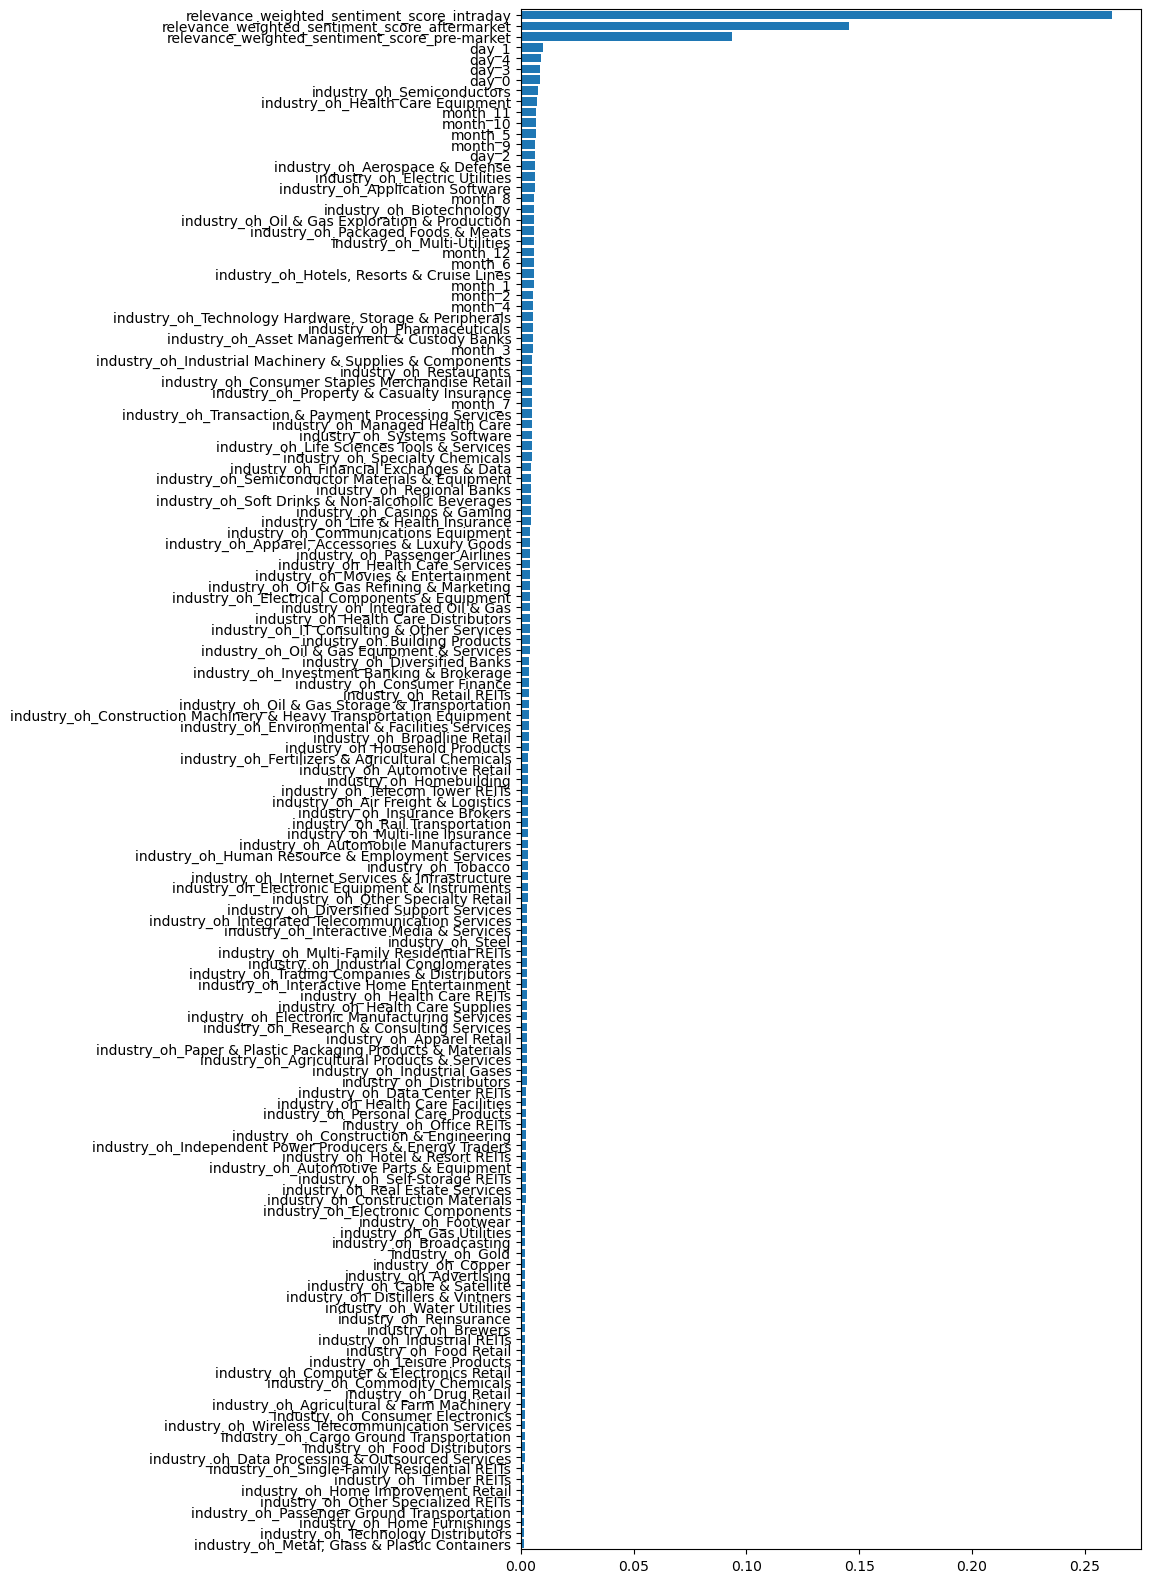

In [32]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,20)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()